# Testing network-level statistics through simulation

The goal of this notebook is to walk you through how to test some basic properties of networks using two different null models: the **Erdos-Renyi model** and the **configuration model**. To begin, we'll import a series of libraries that you'll use for the analysis. Of note is the *networkx* library, which has a bunch of useful tools for analyzing networks in Python. I would also highly recommend the *snap* library which was created and is maintained by [Jure Leskovec's lab at Stanford](http://snap.stanford.edu/), especially if you're analyzing large networks. It requires a bit of work to install, however, and in my opinion has a slightly steeper learning curve than networkx. *seaborn* is a nice plotting tool that is built off of *pyplot*. 

In [14]:
import networkx as nx
import csv
import seaborn as sns
import matplotlib.pyplot as plt
import numpy.random as rand
import random
from networkx.algorithms.assortativity import attribute_assortativity_coefficient as homophily

## Setting up the network

Here we upload the network from a CSV file, which is available on the SICSS GitHub as well as [my personal GitHub page](https://github.com/AustinVL/SICSS_2019_Flash_Talk). The network is drawn from the [Enron email corpus](https://en.wikipedia.org/wiki/Enron_Corpus), which is available in full at the [Carnegie Mellon Computer Science website](https://www.cs.cmu.edu/~enron/). A reduced form the dataset (just the network based off meta-data, no content) is available at the [SNAP website](https://snap.stanford.edu/data/email-Enron.html).

Here we have a severely reduced form of the dataset. Specifically, this is a cumulative communication network of emails amongst the 150 custodians that were identified by a predictive algorithm to contain **expressive communication**, or communication that was perceived as intrinsically worthwhile (e.g. exchanging jokes, gossiping, etc.). This was done in the service of a larger project, but serves as a cool use case for us. I should mention that me and my co-author ([Katariina Mueller-Gastelle](https://sociology.stanford.edu/people/katariina-mueller-gastell)) plan to build a stronger predictive algorithm in the future, so these results might not be reflected in future work.

Each row of the CSV we're using contains a "from" and "to", which denotes who sent at least one email in the observation period to whom, and each node is identified by their name. We call this a **directed edge list**, because the CSV file is a list of the connections between nodes in the network. Other ways to represent the network include an **adjacency matrix**, which is an *nxn* matrix in which any particular entry *ij* denotes whether there is a link from *i* to *j*. Once we load in this information, however, we're actually going to delete the information about the direction of ties and treat the network as undirected (i.e. assume that a tie from *i* to *j* and a tie from *j* to *i* are redundant information).

In [3]:
G = nx.read_edgelist('expressive_edges_150.csv', delimiter=',')
G.remove_node('to')
G.remove_node('from')

Two important pieces of information for us to know about the network is how many nodes and how many edges are in the network. The networkx library has a function to give us exactly these:

In [4]:
n=G.number_of_nodes()
m=G.number_of_edges()

Now we're going to upload a second CSV (also available on the SICSS GitHub as well as [my personal GitHub page](https://github.com/AustinVL/SICSS_2019_Flash_Talk)) which contains information on the gender of each node in the network. Each row of the CSV has the name of the custodian, their gender ('1' for female and '0' for male), and a categorical variable that represents their job at Enron during the data collection period. I only include the gender variable into the network, but one could also apply this exact same framework to analyze behavior by job title. The last line of code in this block computes the proportion of female nodes in the network, which will also be important for us to know as we simulate the network under the null hypothesis.

In [5]:
with open('attributes_expressive_150.csv', 'r') as f:
    reader = csv.DictReader(f)
    gender = {row['Name']: row['Female'] for row in reader}
        
nx.classes.function.set_node_attributes(G, gender, name='female')

g = sum([int(i) for i in gender.values()])/n

Here we calculate two statistics that describe the network:
1. The [average clustering coefficient](https://networkx.github.io/documentation/stable/reference/algorithms/generated/networkx.algorithms.cluster.average_clustering.html#networkx.algorithms.cluster.average_clustering) measures how often there are "triangles" in the network (i.e. where links exists between *i* and *j*, *j* and *k*, and *i* and *k*), normalized by the possible number of triangles given the degree distribution of the network. See the "Network average clustering coefficient" section of [this wikipedia page](https://en.wikipedia.org/wiki/Clustering_coefficient) for an in-depth explanation of the measure.

2. The [assortativity coefficient](https://networkx.github.io/documentation/stable/reference/algorithms/generated/networkx.algorithms.assortativity.attribute_assortativity_coefficient.html#networkx.algorithms.assortativity.attribute_assortativity_coefficient) describes the degree to which "birds of a feather flock together". In our examination of gender, this will tell us whether men are more likely to exchange expressive communication to men and whether women are more likely to exchange expressive communication with women. We could do something more interesting if we included the directed nature of the ties in the analysis, but here we'll try to keep it simple.

In [6]:
cc = float(nx.average_clustering(G))
h = float(homophily(G, 'female'))

## Evaluating the average clustering coefficient

Now we'll test whether the degree to which we observe clustering in our network is more than what we would expect by chance. The question of course is what do we mean when we say "by chance"? This is a question of what our **null model** is. We'll test two null models here, the [Erdos-Renyi model](https://en.wikipedia.org/wiki/Erd%C5%91s%E2%80%93R%C3%A9nyi_model) and the [configuration model](https://en.wikipedia.org/wiki/Configuration_model).

The Erdos-Renyi model takes in two parameters, *n* (the number of nodes in the network) and *m* (the number of edges or connections in the network). Given these two parameters, networkx will randomly generate networks where edges are randomly distributed amongst nodes. There's a slight variation of this model which taken in *n* and *p* (the average number of edges per node), but these two should give similar results over many simulations. So, what we'll do is generate a network under the Erdos-Renyi model 1000 times with the same *n* and *m* as our actual network. For each of these simulations, we'll calculate the average clustering coefficient. The variation in these estimates over many simulations of the network will give us a sense of "what we would expect by chance". From the distribution of the coefficient over these simulations, we can make an educated guess about whether our observed network is drawn from this distribution.

However, you might argue that the Erdos-Reyi model is a little too simple. Random networks don't tend to look like real social (or other) networks in important ways, and therefore showing that our observed network is different than networks simulated under the Erdos-Renyi model might not be particularly interesting. Specifically, real networks have very non-random degree distributions. For instance, many networks have degree distributions that have a long right tail, such that a few nodes have many connections and most nodes have only a few. Networks under the Erdos-Renyi network don't have this feature; they'll approximate a normal degree distribution. 

The configuration model, on the other hand, produces a network with a specified degree distribution, allowing us to make a more interesting comparison. With the configuration model, we can get a sense of what we would expect a random network with a given degree sequence would look like, and then make a probabilistic assesment of whether our observed network was generated under that model. There's two methods to utilizing the configuration model, one that generates networks "from scratch" and one that modifies a pre-existing network. The latter is far more efficient computationally, so let's focus on that. Basically, take a network and randomly select two ties, one that connects *i* and *j* and a second which connects *p* and *q*. Remove these ties and add two new ties: one that connects *i* and *p* and one that connects *j* and *q*. Call this process one "swap". Importantly, note that *i*, *j*, *p*, and *q* all maintain the same number of connections: we just add randomness to whom they are connected. By performing many random "swaps" we generate a random network with the same degree sequence as the original network. Again, we'll generate many networks generated under this null model to give us a sense of what values of our outcome we would expect "by chance". We can then compare our observed value to this distribution of the outcome given the null hypothesis and make a probabilistic assesment of whether or not our network was drawn from that distribution.

Now, as complicated as all this might sound, simulating 1000 networks each under these two models and storing them for analysis is a grand total of 2 lines of code:

In [24]:
random.seed(2019)
cc_er = [nx.average_clustering(nx.gnm_random_graph(n, m)) for i in range(1000)]
cc_config = [nx.average_clustering(nx.double_edge_swap(G.copy(), nswap=500, max_tries=750)) for i in range(1000)]

Now, to analyze our results we'll make a plot as well as output a one-tailed p-value. To calculate p-values, we simply estimate the probability that our null model would generate a test-statistic that is higher than our observed network. You could argue that we should be calculating a two-tailed p-value, in which case you could make a (sometimes) reasonable assumption about the shape of the distribution and just divide our one-tailed p-value by two, or you could measure the distance from the mean (or median) of the distribution. Nonetheless, let's just use one-tailed p-values here.

C:\Users\Austin\Anaconda3\lib\site-packages\scipy\stats\stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


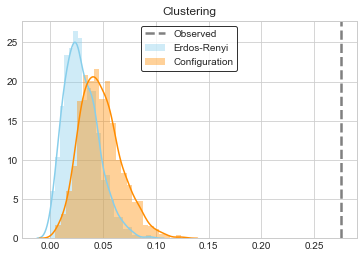

P-value for Erdos-Renyi model: 0.0
P-value for Configuration model: 0.0


In [25]:
sns.set_style('whitegrid')
hist1 = sns.distplot(cc_er, color="skyblue", label="Erdos-Renyi")
hist2 = sns.distplot(cc_config, color='darkorange', label="Configuration")
hist1.axvline(cc, 0,100, color='grey', lw=2.5, ls="--", label='Observed')
leg = plt.legend(frameon=True)
leg.get_frame().set_edgecolor('black')
plt.title('Clustering')
plt.show() 

print("P-value for Erdos-Renyi model: {}".format(sum(cc < i for i in cc_er)/1000))
print("P-value for Configuration model: {}".format(sum(cc < i for i in cc_config)/1000))

Given this evidence, we can be fairly certain that our network was not generated under the Erdos-Renyi model nor was it generated under the configuration model. That is, there's something that we're not modeling that accounts for the observed level of clustering. Heider's balance theory seems like an obvious candidate, but you could probably also make other arguments like how instrumental (i.e. non-expressive) interactions within organizations are clustered by department, and that expressive communication is likely to co-occur with repeated instrumental interaction. These are things we could model in a manner very similar to this, but we won't do so here.

## Evaluating the assortativity coefficient

Now we'll repeat roughly the same procedure for the degree of homophily in the network. Importantly, when we simulate our network under the Erdos-Renyi model here, we'll also need to make a decision about the proportion of nodes in each generated network that are women (for the configuration model we won't have to worry about this since we're just re-wiring the observed network). For simplicity, we'll just assign nodes to be a women at random with probability equal to the proportion of women we observe in our empirical network (about 30%). Note that we could have made other decisions: for instance, we could have fixed the number of women like we do in simulating our network under the configuration model. This is something you would want to make sure your results are robust to. Nonetheless, below I define a simple function that will simulate a network under the Erdos-Renyi model, and will create nodes with two different values of a single attributes, the proportions of which are governed by a parameter *g*.

In [9]:
def attribute_er(g, n, m):
    G = nx.gnm_random_graph(n, m)
    gender = {i: rand.choice(['0','1'],p=[1-g,g]) for i in range(n)}
    nx.classes.function.set_node_attributes(G, gender, name='female')
    return G

Using this function along with the same code as above for the configuration model, we'll simulate our network under our two null models 1000 times:

In [22]:
random.seed(2019)
h_er = [homophily(attribute_er(g,n,m), 'female') for i in range(1000)]
h_config = [homophily(nx.double_edge_swap(G.copy(), nswap=500, max_tries=750), 'female') for i in range(1000)]

And then analyze them as we did before:

C:\Users\Austin\Anaconda3\lib\site-packages\scipy\stats\stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


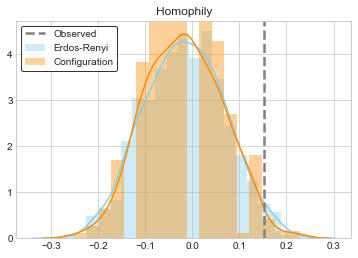

P-value for Erdos-Renyi model: 0.054
P-value for Configuration model: 0.038


In [23]:
sns.set_style('whitegrid')
hist1 = sns.distplot(h_er, color="skyblue", label="Erdos-Renyi")
hist2 = sns.distplot(h_config, color='darkorange', label="Configuration")
hist1.axvline(h, 0,100, color='grey', lw=2.5, ls="--", label='Observed')
hist1.legend()
leg = plt.legend(frameon=True)
leg.get_frame().set_edgecolor('black')
plt.title('Homophily')
plt.show()
print("P-value for Erdos-Renyi model: {}".format(sum(h < i for i in h_er)/1000))
print("P-value for Configuration model: {}".format(sum(h < i for i in h_config)/1000))

So here we get diverging results from the two models! One gives us an answer that would generally be accepted as "significant" while the other does not. So, we can meaningfully reject the hypothesis that our network was generated from the Erdos-Renyi model, but we can't reject the hypothesis that it was generated under the configuration model. What to do with these results? Great question!

The current set of analyses is what we used to get grant funding for more serious coding of emails, which we then plan to use to train a (hopefully) better classifier, after which we will re-evaluate these results.

Hopefully you found this exercise useful! Please feel free to reach out to me with any questions! Also, if you were interested in my potential alternative talk ("using machine learning for causal inference"), check out the teaching materials on my personal website!

* Email: <avanloon@stanford.edu>
* Personal website: <https://ankenyav.wixsite.com/austinvanloon>